In [ ]:
!pip install -q kaggle


In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


rm: cannot remove '/root/.kaggle': No such file or directory


# **geting data for the first dataset (organic or none organic)**

In [6]:
! kaggle datasets download -d techsash/waste-classification-data

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 94% 403M/427M [00:01<00:00, 245MB/s]
100% 427M/427M [00:01<00:00, 249MB/s]


In [7]:
!unzip -q waste-classification-data.zip

In [ ]:
!pip install pyautogui


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61.2/61.2 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 171.2/171.2 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 132.8/132.8 kB 15.8 MB/

# **training and testing the binary classification model**

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/3
706/706 [==============================] - 904s 1s/step - loss: 0.1590 - accuracy: 0.9386 - val_loss: 0.3723 - val_accuracy: 0.8309
Epoch 2/3
79/79 [==============================] - 11s 136ms/step - loss: 0.3919 - accuracy: 0.8444
Test accuracy: 0.8444


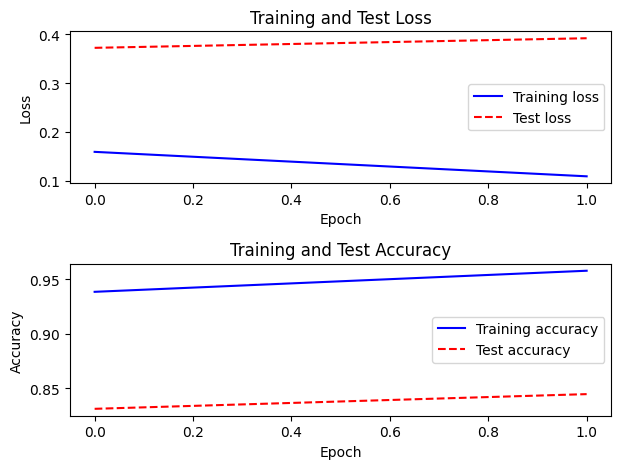

In [8]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import ssl
import certifi


ssl._create_default_https_context = ssl._create_unverified_context

train_dir = '/content/DATASET/TRAIN'
test_dir = '/content/DATASET/TEST'
img_height, img_width = 384, 512
num_classes = 2

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Data generator for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# batch 1: Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='categorical'
)

# batch 2: Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    class_mode='categorical'
)

#  the EfficientNetV2 model
#base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
#base_model.trainable = False

#the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1)

# Train the model
epochs = 3
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.4f}")

model_save_path_hdf5 = '/content/model_saved1.h5'
model.save(model_save_path_hdf5)

# figure creator
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Test loss", linestyle="--")
ax1.set_title('Training and Test Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Test accuracy", linestyle="--")
ax2.set_title('Training and Test Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

model.save('model_saved1.h5')


# **geting data for the secound dataset ('Cardboard', 'Glass', 'Metal', 'Paper', 'Plastics')**

In [1]:
! kaggle datasets download -d aminizahra/recycling2

Dataset URL: https://www.kaggle.com/datasets/aminizahra/recycling2
License(s): unknown
 77% 33.0M/43.0M [00:00<00:00, 91.0MB/s]
100% 43.0M/43.0M [00:00<00:00, 96.6MB/s]


In [2]:
!unzip -q recycling2.zip

# **training and testing the secound CNN model**

Found 1914 images belonging to 5 classes.
Class indices: {'Cardboard': 0, 'Glass': 1, 'Metal': 2, 'Paper': 3, 'Plastics': 4}
Class names: ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastics']
Found 476 images belonging to 5 classes.
Epoch 1/5
60/60 [==============================] - 129s 2s/step - loss: 0.4356 - accuracy: 0.8380 - val_loss: 0.4110 - val_accuracy: 0.8718
Epoch 2/5
60/60 [==============================] - 101s 2s/step - loss: 0.2130 - accuracy: 0.9122 - val_loss: 0.3711 - val_accuracy: 0.8782
Epoch 3/5
60/60 [==============================] - 100s 2s/step - loss: 0.1682 - accuracy: 0.9399 - val_loss: 0.3645 - val_accuracy: 0.8803
Epoch 4/5
15/15 [==============================] - 20s 1s/step - loss: 0.3738 - accuracy: 0.8887
Validation accuracy: 0.8887


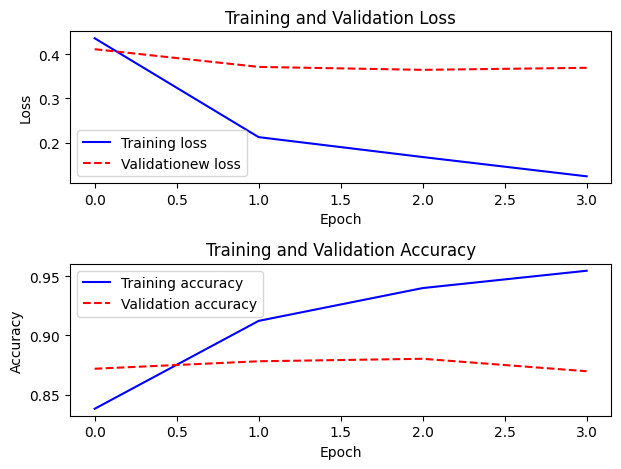

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB7
import matplotlib.pyplot as plt
import ssl
import certifi
import numpy as np
import cv2

ssl._create_default_https_context = ssl._create_unverified_context

train_dir = '/content/Train'
img_height, img_width = 384, 512
num_classes = 5


def custom_preprocessing(image):

    # Randomly apply filters
    choice = np.random.choice(['gaussian', 'mean', 'median', 'laplacian', 'none'])

    if choice == 'gaussian':
        image = cv2.GaussianBlur(image, (5, 5), 0)
    elif choice == 'mean':
        image = cv2.blur(image, (5, 5))
    elif choice == 'median':
        image = cv2.medianBlur(image, 5)

    # Randomly flip the image
    flip_choice = np.random.choice(['vertical', 'horizontal', 'none'])
    if flip_choice == 'vertical':
        image = cv2.flip(image, 0)
    elif flip_choice == 'horizontal':
        image = cv2.flip(image, 1)

    image = tf.keras.applications.efficientnet.preprocess_input(image)

    return image

# Data augmentation with custom preprocessing function
datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

# batch 1
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='training'
)
class_indices = train_generator.class_indices

print("Class indices:", class_indices)


class_names = sorted(class_indices, key=class_indices.get)
print("Class names:", class_names)

# batch 2
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='validation'
)

# the EfficientNetB7 model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
epochs = 6
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_acc = model.evaluate(validation_generator, steps=len(validation_generator))
print(f"Validation accuracy: {val_acc:.4f}")




# figure creator
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validationew loss", linestyle="--")
ax1.set_title('Training and Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy", linestyle="--")
ax2.set_title('Training and Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

model_save_path_hdf5 = '/content/model_saved.h5'
model.save(model_save_path_hdf5)

In [ ]:
! pip install inference-sdk


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 86.7/86.7 kB 5.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 49.4/49.4 kB 5.6 MB/s eta 0:00:00


# **geting data for YOLOv8 model**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WhsnCFpPq6dyIasQeRBk")
project = rf.workspace("digital-erg").project("hazmat-placards")
version = project.version(4)
dataset = version.download("yolov8")


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 71.4/71.4 kB 860.8 kB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 158.3/158.3 kB 3.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 178.7/178.7 kB 6.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 49.1/49.1 MB 4.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-pyt

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Hazmat-Placards-4 in yolov8:: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12174/12174 [00:04<00:00, 2937.60it/s]


In [ ]:
!pip install -q torch torchvision torchaudio

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23.7/23.7 MB 35.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 823.6/823.6 kB 38.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14.1/14.1 MB 57.6 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

# **getting yolov8 model**

In [ ]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 22970, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 22970 (delta 122), reused 126 (delta 54), pack-reused 22723
Receiving objects: 100% (22970/22970), 13.72 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (16034/16034), done.


In [ ]:
%cd /content/ultralytics


/content/ultralytics


# **training and testing the YOLOv8 model**

In [ ]:
from ultralytics import YOLO

# Load a model

model = YOLO("yolov8n.pt")

# Use the model
model.train(data="/content/Hazmat-Placards-4/data.yaml", epochs=10)
metrics = model.val()
path = model.export(format="onnx")

Ultralytics YOLOv8.1.27 üöÄ Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Hazmat-Placards-4/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning /content/Hazmat-Placards-4/train/labels.cache... 5300 images, 60 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5300/5300 [00:00<?, ?it/s]

WARNING ‚ö†Ô∏è Box and segment counts should be equal, but got len(segments) = 920, len(boxes) = 9366. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Hazmat-Placards-4/valid/labels.cache... 518 images, 8 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 518/518 [00:00<?, ?it/s]

WARNING ‚ö†Ô∏è Box and segment counts should be equal, but got len(segments) = 85, len(boxes) = 985. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /content/ultralytics/runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ‚úÖ
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/ultralytics/runs/detect/train10
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.92G     0.8272      3.263      1.052          6        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:53<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.62it/s]


                   all        518        985      0.666      0.576      0.616      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.78G     0.7841      1.791          1          6        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:45<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.63it/s]


                   all        518        985      0.819      0.689      0.817      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.79G     0.7639      1.347     0.9808          9        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:45<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.57it/s]


                   all        518        985      0.805      0.826      0.879      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.79G     0.7415      1.057      0.968          8        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:43<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.62it/s]


                   all        518        985      0.823       0.87      0.892      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.79G     0.7157     0.8678     0.9548         11        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:46<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.65it/s]

                   all        518        985      0.788      0.908      0.923      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.79G     0.6929      0.738     0.9457          5        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:44<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.80it/s]

                   all        518        985      0.897      0.917      0.934      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.77G       0.66     0.6452     0.9276         10        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:46<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.66it/s]

                   all        518        985      0.913      0.895      0.937      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.79G      0.637     0.5708     0.9185          7        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:45<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.67it/s]

                   all        518        985      0.913      0.907       0.93      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.79G     0.6162     0.5204     0.9096          5        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:45<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:05<00:00,  2.86it/s]


                   all        518        985      0.933      0.906      0.951      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.79G     0.5906     0.4772     0.8937         13        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 332/332 [01:44<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:05<00:00,  2.92it/s]

                   all        518        985      0.925        0.9       0.94      0.774



10 epochs completed in 0.316 hours.
Optimizer stripped from /content/ultralytics/runs/detect/train10/weights/last.pt, 6.3MB
Optimizer stripped from /content/ultralytics/runs/detect/train10/weights/best.pt, 6.3MB

Validating /content/ultralytics/runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.1.27 üöÄ Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3008573 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:08<00:00,  2.05it/s]


                   all        518        985      0.933      0.906      0.951      0.774
           ERIrotation        518         33      0.771      0.879      0.912      0.789
              Placards        518        118      0.891      0.758      0.883      0.698
             corrosive        518         58      0.973      0.983      0.988      0.801
    dangerous-when-wet        518         60      0.918      0.931      0.976      0.793
             explosive        518         95      0.907      0.979      0.979      0.783
             flammable        518         69      0.969      0.942      0.991      0.787
       flammable-solid        518         64      0.983      0.927      0.986      0.785
  infectious-substance        518         65       0.96      0.954      0.991      0.793
         license plate        518          9       0.72      0.573      0.676      0.415
     non-flammable-gas        518         64      0.956      0.953      0.991      0.845
      organic-peroxid

val: Scanning /content/Hazmat-Placards-4/valid/labels.cache... 518 images, 8 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 518/518 [00:00<?, ?it/s]

WARNING ‚ö†Ô∏è Box and segment counts should be equal, but got len(segments) = 85, len(boxes) = 985. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 33/33 [00:08<00:00,  3.83it/s]


                   all        518        985      0.933      0.906      0.951      0.773
           ERIrotation        518         33      0.772      0.879      0.912       0.79
              Placards        518        118      0.891      0.759      0.884      0.697
             corrosive        518         58      0.973      0.983      0.988      0.802
    dangerous-when-wet        518         60      0.918      0.932      0.976        0.8
             explosive        518         95      0.907      0.979      0.979      0.783
             flammable        518         69      0.969      0.942      0.991      0.785
       flammable-solid        518         64      0.983      0.927      0.986      0.791
  infectious-substance        518         65       0.96      0.954      0.991      0.792
         license plate        518          9      0.719      0.571      0.676      0.389
     non-flammable-gas        518         64      0.957      0.953      0.991      0.847
      organic-peroxid

https://colab.research.google.com/drive/1ERXQ2x_v7BGaOX8-juy2IeJBWXvlpicC?usp=sharing